In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bosonStar import *
from util import *

from ctypes import *
file = "./grav.so"
my_func = CDLL(file)

#Middle
massInCU = 2e-77
aInCU = 1e-73
totalMassInCU = 0.1
dtInCU = 2500.0
bigT = 5000

Solving for a pure boson star
Big Lambda: 10000

Results of the fourth order ODE solver:
farPoint (0-1, check if too close to boundary values): 0.704678
A2 (0.001-15.0, check if too close to boundary values): 0.319763
Furthest solved star: 8952.01
MCU 0.2686418565004144
Solving for a pure boson star
Big Lambda: 10000

Results of the fourth order ODE solver:
farPoint (0-1, check if too close to boundary values): 0.75819
A2 (0.001-15.0, check if too close to boundary values): 0.484712
Furthest solved star: 15786.8
MCU 0.11173489585598817
Solving for a pure boson star
Big Lambda: 10000

Results of the fourth order ODE solver:
farPoint (0-1, check if too close to boundary values): 0.741334
A2 (0.001-15.0, check if too close to boundary values): 0.499632
Furthest solved star: 16512.2
MCU 0.10153936398602499
Solving for a pure boson star
Big Lambda: 10000

Results of the fourth order ODE solver:
farPoint (0-1, check if too close to boundary values): 0.752996
A2 (0.001-15.0, check if too clos

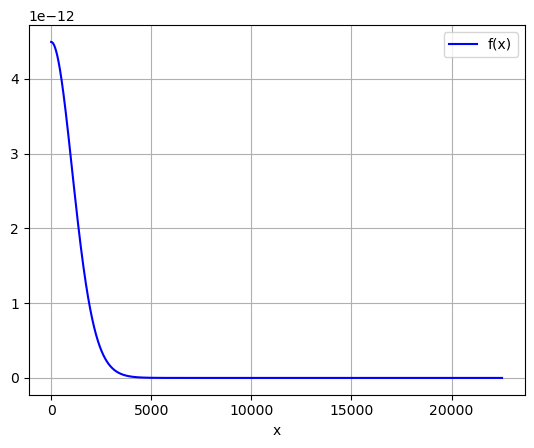

(1330,)


In [2]:
allThings = outputProfile(massInCU, aInCU, totalMassInCU, 4000)
#Hot Fix
x = allThings["x"][1::2]
psi = allThings["profile"][1::2]

dx = x[1]-x[0]
#for i in range(335):
#    x = np.append(x, x[-1]+dx)
#    psi = np.append(psi, psi[-1])

print(x.shape)

In [3]:
totalMass = massSIToPlanckUnit(massCodeUnitToSI(totalMassInCU))
m = massSIToPlanckUnit(massCodeUnitToSI(massInCU))
a = lengthSIToPlanckUnit(lengthCodeUnitToSI(aInCU))
N = totalMass/m
Ra = np.sqrt(a/m/m/m)
omegaA = m*m/np.abs(a)
epsilon = 1.0/omegaA/m/Ra/Ra
a0 = np.sqrt(1.0/omegaA/m)
delta = 4.0*np.pi*a*N/a0
GM = totalMass/Ra/Ra/Ra/omegaA/omegaA

print("R:", Ra)
print("Omega:" ,omegaA)
print("Epsilon (Should be 1):", epsilon)
print("Delta:", delta)
print("New G:", GM)

R: 3.8684718785837514e+40
Omega: 3.656129092998465e-43
Epsilon (Should be 1): 1.0000000000000002
Delta: 14.839459489461666
New G: 1.180886665279879


In [4]:
x = lengthSIToPlanckUnit(lengthCodeUnitToSI(x))/Ra
x = np.concatenate((np.flip(-x), x))

psi = np.sqrt(densitySIToPlanckUnit(densityCodeUnitToSI(psi))/totalMass)*np.power(Ra, 3.0/2.0)
psi = np.concatenate((np.flip(psi), psi))
normalization = np.trapz(2.0*np.pi*x*x*np.absolute(psi)*np.absolute(psi), x)
psi = psi/normalization
psi = psi.astype(complex)

size = len(psi)
dt = timeSIToPlanckUnit(timeCodeUnitToSI(dtInCU))*omegaA
dx = x[1]-x[0]

print(psi)
print(dt)

[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
0.08351027137908527


In [5]:
T = np.zeros((size,size)).astype(complex)
TSph = np.zeros((size,size)).astype(complex)
Q = np.zeros((size,size)).astype(complex)
V2Grav = np.zeros((size,size)).astype(complex)
I = np.identity(size).astype(complex)
phi = np.zeros((size))

In [6]:
def setupT():
    global T, TSph
    for i in range(size):
        if i==0:
            T[i][i] = -5.0/2.0 + 4.0/3.0 - 1.0/12.0
            T[i][i+1] = 4.0/3.0
            T[i][i+2] = -1.0/12.0
            TSph[i][i+1] = 1.0/2.0/x[i]
            TSph[i][i] = -1.0/2.0/x[i]
        elif i==1:
            T[i][i-1] = 4.0/3.0 -1.0/12.0
            T[i][i] = -5.0/2.0
            T[i][i+1] = 4.0/3.0
            T[i][i+2] = -1.0/12.0
            TSph[i][i+1] = 1.0/2.0/x[i]
            TSph[i][i-1] = -1.0/2.0/x[i]
        elif i==size-2:
            T[i][i-2] = -1.0/12.0
            T[i][i-1] = 4.0/3.0
            T[i][i] = -5.0/2.0
            T[i][i+1] = 4.0/3.0 - 1.0/12.0
            TSph[i][i+1] = 1.0/2.0/x[i]
            TSph[i][i-1] = -1.0/2.0/x[i]
        elif i==size-1:
            T[i][i-2] = -1.0/12.0
            T[i][i-1] = 4.0/3.0
            T[i][i] = -5.0/2.0 + 4.0/3.0 -1.0/12.0
            TSph[i][i-1] = -1.0/2.0/x[i]
            TSph[i][i] = 1.0/2.0/x[i]
        else:
            T[i][i-2] = -1.0/12.0
            T[i][i-1] = 4.0/3.0
            T[i][i] = -5.0/2.0
            T[i][i+1] = 4.0/3.0
            T[i][i+2] = -1.0/12.0
            TSph[i][i+1] = 1.0/2.0/x[i]
            TSph[i][i-1] = -1.0/2.0/x[i]

    T = -1.0/2.0/dx/dx*T
    TSph = -1.0/dx*TSph

def setupQ():
    global Q
    for i in range(size):
        Q[i][i] = delta*np.absolute(psi[i])*np.absolute(psi[i])

def setupV2Grav():
    global V2Grav, phi, psi

    rho = np.absolute(psi)[size//2:]*np.absolute(psi)[size//2:]
    rho_c = (c_double * size)(*rho)
    phi_c = (c_double * size)(*np.absolute(phi)[size//2:])
    my_func.findGravRho(rho_c, phi_c, c_int(size//2), c_double(dx))
    for i in range(size//2):
        place = int(size//2 + i)
        phi[place] = phi_c[i] * GM

    for i in range(size//2):
        V2Grav[i][i] = phi[size-i-1]
        V2Grav[size-i-1][size-i-1] = phi[size-i-1]
            
        phi[i] = phi[size-i-1] #Regulate

def setupU1U2():
    global U1, U2
    U1 = I + 1.0j*dt/2.0*(T+TSph+Q+V2Grav)
    U2 = I - 1.0j*dt/2.0*(T+TSph+Q+V2Grav)

0 0.0 0.05840260765251017 1.0000269241749196
1 0.08351027137908527 0.05840158191872417 1.0000269241924462
2 0.16702054275817055 0.058401739101999715 1.0000269242429232
3 0.2505308141372558 0.05840081569816016 1.0000269242996616
4 0.3340410855163411 0.05840063395349599 1.0000269243833921
5 0.4175513568954264 0.05839976319562167 1.0000269244770643
6 0.5010616282745116 0.05839934902038797 1.0000269245935829
7 0.5845718996535969 0.058398504323795335 1.0000269247221987
8 0.6680821710326822 0.058397917864317125 1.0000269248705316
9 0.7515924424117675 0.058397082920196595 1.00002692503225
10 0.8351027137908528 0.05839636388336062 1.0000269252112222
11 0.9186129851699381 0.058395528150023496 1.0000269254043066
12 1.0021232565490232 0.058394704826048714 1.000026925612651
13 1.0856335279281086 0.058393861369095246 1.000026925835448
14 1.1691437993071938 0.05839295484747581 1.000026926071858
15 1.2526540706862792 0.058392099126255155 1.000026926322787
16 1.3361643420653644 0.058391125605419994 1.

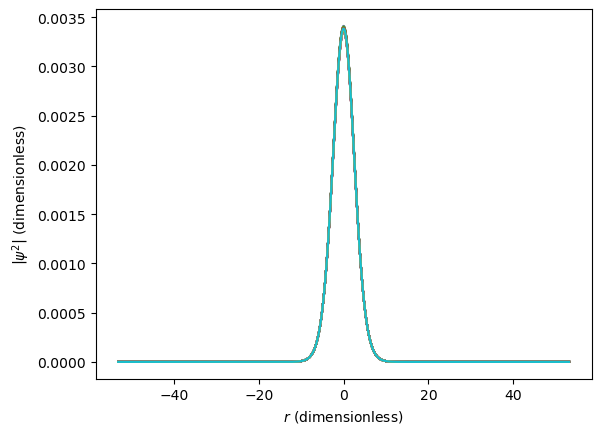

In [7]:
setupT()
setupQ()
setupV2Grav()
setupU1U2()


#Record
gravitationalForce = []
pressureGradient = []
quantumPressure = []

hello = []
ts = []
oldGM = GM
newGM = GM*1.01
for t in range(bigT):
    #Pertubation
    #if(t*dt<2.0):
    #    GM = newGM
    #if(t*dt>=2.0):
    #    GM = oldGM

    setupQ()
    setupV2Grav()
    setupU1U2()
    psi = np.linalg.solve(U2, np.dot(U1,psi))

    #Regulate
    for i in range(size//2):
        psi[i] = psi[size-i-1]

    normalization = np.trapz(2.0*np.pi*x*x*np.absolute(psi)*np.absolute(psi), x)
    if(normalization >= 1.01):
        break
    print(t, t*dt, np.absolute(psi[size//2]), normalization)
    if(GM == oldGM):
        hello.append(np.absolute(psi[size//2])*np.absolute(psi[size//2]))
        ts.append(t*dt)

        #Record
        rho0 = (np.absolute(psi[size//2 + 14])*np.absolute(psi[size//2 + 14]))/Ra/Ra/Ra*totalMass
        rho1 = (np.absolute(psi[size//2 + 15])*np.absolute(psi[size//2 + 15]))/Ra/Ra/Ra*totalMass
        rho2 = (np.absolute(psi[size//2 + 16])*np.absolute(psi[size//2 + 16]))/Ra/Ra/Ra*totalMass
        rho3 = (np.absolute(psi[size//2 + 17])*np.absolute(psi[size//2 + 17]))/Ra/Ra/Ra*totalMass
        Q0 = -((np.sqrt(rho0) -2*np.sqrt(rho1) + np.sqrt(rho2))/(dx*Ra)/(dx*Ra) + 2.0/(x[size//2 + 15]*Ra)*(np.sqrt(rho1)-np.sqrt(rho0))/(dx*Ra))/np.sqrt(rho1)/2.0/m
        Q1 = -((np.sqrt(rho1) -2*np.sqrt(rho2) + np.sqrt(rho3))/(dx*Ra)/(dx*Ra) + 2.0/(x[size//2 + 16]*Ra)*(np.sqrt(rho2)-np.sqrt(rho1))/(dx*Ra))/np.sqrt(rho2)/2.0/m

        gravitationalForce.append((phi[size//2 + 16]-phi[size//2 + 15])/dx)
        pressureGradient.append(4.0*np.pi*a/m/m/m*(rho2-rho1)/(dx*Ra)/Ra/omegaA/omegaA)
        quantumPressure.append((Q1-Q0)/m/(dx*Ra)/Ra/omegaA/omegaA)

    if t%100 == 0:
        plt.plot(x, np.absolute(psi)*np.absolute(psi))

plt.xlabel(r"$r$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

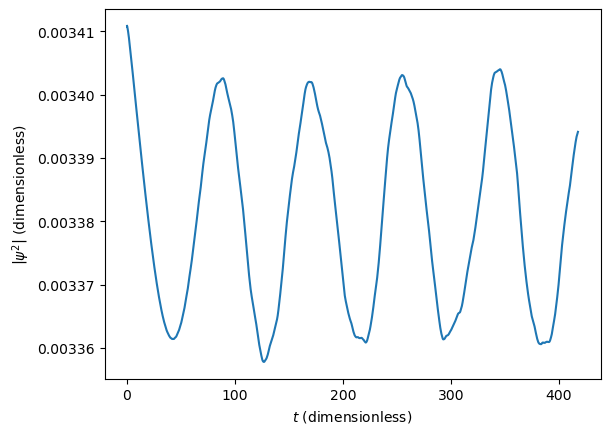

In [8]:
plt.plot(ts, hello)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

Text(0.5, 0, 'f (1/s)')

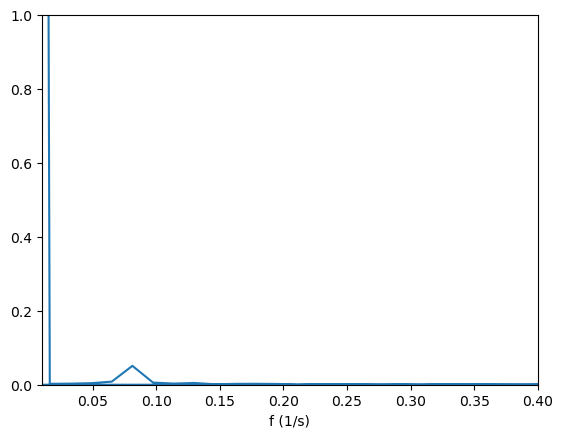

In [9]:
sp = np.fft.fft(hello)
freq = np.fft.fftfreq(len(hello), d=dt)*omegaA/5.391247e-44

plt.plot(freq, np.absolute(sp))
plt.xlim(0.01,0.4)
plt.ylim(0.0,1.0)
plt.xlabel("f (1/s)")

In [10]:
print(freq[1]-freq[0])
for i in range(len(freq)-1):
    if(freq[i] > 0.0 and np.absolute(sp[i]) > 0.03 and np.absolute(sp[i])>np.absolute(sp[i+1]) and np.absolute(sp[i])>np.absolute(sp[i-1])):
        print(freq[i], np.absolute(sp[i]))

0.016241360000000003
0.08120680000000001 0.051080472098608005


[6.42297479e-07 6.42290001e-07 6.42229674e-07 ... 6.42229674e-07
 6.42290001e-07 6.42297479e-07]


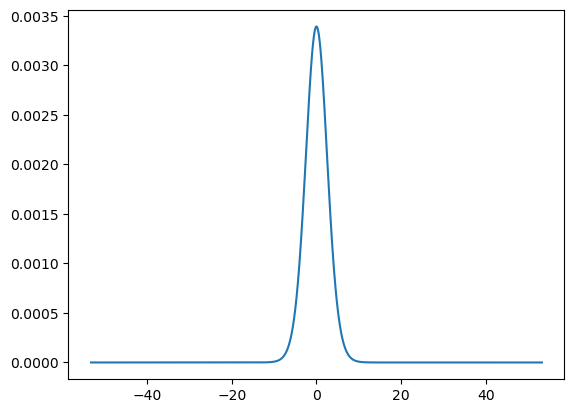

In [11]:
plt.plot(x, np.absolute(psi)*np.absolute(psi))
print(np.absolute(psi))

Middle
0.071-0.081			M1 (M2: 0.142-0.162, M3: 0.213-0.243, M4: 0.284-0.324, M5: 0.355-0.405)
0.132-0.137			M1?
0.158-0.163			M2
0.193-0.204			M1?
0.239-0.249			M3
0.295-0.305			M4
0.361-0.371			M5

0.076-0.086			M1
0.132-0.142			M1?
0.158-0.168			M2

Small
0.097-0.107		M1
0.163-0.173		M1?
0.214-0.224		M2
0.270-0.280		M1?
0.341-0.351		M3
0.432-0.443		M4
0.534-0.544		M5
0.651-0.661		M6

Heavy
0.031-0.037		M1
0.058-0.065		M2
0.072-0.078		M?
0.082-0.089		M?
0.099-0.167 	M3
0.116-0.123		M4
0.140-0.147		M5
0.167-0.173		M6?
0.194-0.201 	M7?

In [12]:
print(psi)

[6.37726966e-07-7.64876954e-08j 6.37716184e-07-7.65148019e-08j
 6.37651612e-07-7.65465676e-08j ... 6.37651612e-07-7.65465676e-08j
 6.37716184e-07-7.65148019e-08j 6.37726966e-07-7.64876954e-08j]


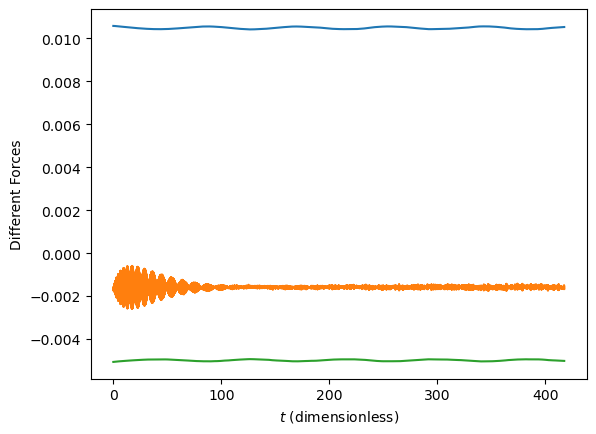

In [13]:
plt.plot(ts, gravitationalForce)
plt.plot(ts, quantumPressure)
plt.plot(ts, pressureGradient)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"Different Forces")
plt.show()